In [ ]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip ocular-disease-recognition-odir5k.zip
!mkdir ODIR-5K/Validation_Images

In [4]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob
import random

BATCH_SIZE = 32
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

training_images_file = 'ODIR-5K/Training Images'
testing_images_file = 'ODIR-5K/Testing Images'
labels_file = 'ODIR-5K/ODIR-5K/data.xlsx'

diseases = {'abnormal pigment ': 'O', 'age-related macular degeneration': 'A', 'anterior segment image': 'DELETE', 'arteriosclerosis': 'O', 'asteroid hyalosis': 'O', 'atrophic change': 'O', 'atrophy': 'O', 'branch retinal artery occlusion': 'O', 'branch retinal vein occlusion': 'O', 'cataract': 'C', 'central retinal artery occlusion': 'O', 'central retinal vein occlusion': 'O', 'central serous chorioretinopathy': 'O', 'chorioretinal atrophy': 'O', 'chorioretinal atrophy with pigmentation proliferation': 'O', 'choroidal nevus': 'NaN', 'congenital choroidal coloboma': 'O', 'depigmentation of the retinal pigment epithelium': 'O', 'diabetic retinopathy': 'D', 'diffuse chorioretinal atrophy': 'O', 'diffuse retinal atrophy': 'O', 'drusen': 'O', 'dry age-related macular degeneration': 'A', 'epiretinal membrane': 'O', 'epiretinal membrane over the macula': 'O', 'fundus laser photocoagulation spots': 'O', 'glaucoma': 'G', 'glial remnants anterior to the optic disc': 'O', 'hypertensive retinopathy': 'H', 'hypertensive retinopathy,diabetic retinopathy': 'D', 'idiopathic choroidal neovascularization': 'O', 'image offset': 'DELETE', 'intraretinal hemorrhage': 'O', 'intraretinal microvascular abnormality': 'O', 'laser spot': 'O', 'lens dust': 'DELETE', 'low image quality': 'DELETE', 'low image quality,maculopathy': 'DELETE', 'macular coloboma': 'O', 'macular epiretinal membrane': 'O', 'macular hole': 'O', 'macular pigmentation disorder': 'NaN', 'maculopathy': 'O', 'mild nonproliferative retinopathy': 'D', 'moderate non proliferative retinopathy': 'D', 'morning glory syndrome': 'O', 'myelinated nerve fibers': 'O', 'myopia retinopathy': 'M', 'myopic maculopathy': 'M', 'myopic retinopathy': 'M', 'no fundus image': 'DELETE', 'normal fundus': 'N', 'old branch retinal vein occlusion': 'O', 'old central retinal vein occlusion': 'O', 'old chorioretinopathy': 'O', 'old choroiditis': 'O', 'optic disc edema': 'O', 'optic discitis': 'O', 'optic disk epiretinal membrane': 'O', 'optic disk photographically invisible': 'DELETE', 'optic nerve atrophy': 'O', 'oval yellow-white atrophy': 'O', 'pathological myopia': 'M', 'peripapillary atrophy': 'O', 'pigment epithelium proliferation': 'O', 'pigmentation disorder': 'O', 'post laser photocoagulation': 'O', 'post retinal laser surgery': 'O', 'proliferative diabetic retinopathy': 'D', 'punctate inner choroidopathy': 'O', 'refractive media opacity': 'O', 'retina fold': 'O', 'retinal artery macroaneurysm': 'O', 'retinal detachment': 'O', 'retinal pigment epithelial hypertrophy': 'O', 'retinal pigment epithelium atrophy': 'O', 'retinal pigmentation': 'O', 'retinal vascular sheathing': 'O', 'retinitis pigmentosa': 'O', 'retinochoroidal coloboma': 'O', 'rhegmatogenous retinal detachment': 'O', 'severe nonproliferative retinopathy': 'D', 'severe proliferative diabetic retinopathy': 'D', 'silicone oil eye': 'O', 'spotted membranous change': 'O', 'suspected abnormal color of  optic disc': 'O', 'suspected cataract': 'C', 'suspected diabetic retinopathy': 'D', 'suspected glaucoma': 'G', 'suspected macular epimacular membrane': 'O', 'suspected microvascular anomalies': 'O', 'suspected moderate non proliferative retinopathy': 'D', 'suspected retinal vascular sheathing': 'O', 'suspected retinitis pigmentosa': 'O', 'suspicious diabetic retinopathy': 'D', 'tessellated fundus': 'O', 'vascular loops': 'O', 'vessel tortuosity': 'O', 'vitreous degeneration': 'O', 'vitreous opacity': 'O', 'wedge white line change': 'O', 'wedge-shaped change': 'O', 'wet age-related macular degeneration': 'A', 'white vessel': 'O'}

#load labels to pandas
labels = pd.read_excel(labels_file, index_col=0) 
print(labels['Left-Diagnostic Keywords'][0])

cataract


Labeling Images by renaming them, removing low quality images 

In [5]:
file_path = 'ODIR-5K/ODIR-5K/Training Images'
all_paths = []
for element in glob.glob(file_path+"/*.jpg"):
  all_paths.append(element)
paths = []

#adding label information to image names
for u_id in labels.index:
  labelL = ""
  labelR = ""
  diagnosticL = labels['Left-Diagnostic Keywords'][u_id]
  diagnosticR = labels['Right-Diagnostic Keywords'][u_id]
  diagnosticL = diagnosticL.split("，") 
  diagnosticR = diagnosticR.split("，") 
  for d in diagnosticL:
    if d in diseases:
        if labelL != "":
          labelL+="&"+diseases[d]
        else:
          labelL+=diseases[d]
    else:
        labelL+="DELETE"
  for d in diagnosticR:
    if d in diseases:
      if labelR != "":
        labelR+="&"+diseases[d]
      else:
        labelR+=diseases[d]
    else:
      labelR+="DELETE"

  if file_path+"/"+str(labels['Left-Fundus'][u_id]) in all_paths:
    filename = str(labels['Left-Fundus'][u_id]).split(".")
    os.rename(file_path+"/"+str(labels['Left-Fundus'][u_id]), file_path+"/"+filename[0]+"-"+labelL+".jpg")
    paths.append(file_path+"/"+str(labels['Left-Fundus'][u_id])+"/"+labelL)

  if file_path+"/"+str(labels['Right-Fundus'][u_id]) in all_paths:
    filename = str(labels['Right-Fundus'][u_id]).split(".")
    os.rename(file_path+"/"+str(labels['Right-Fundus'][u_id]), file_path+"/"+filename[0]+"-"+labelR+".jpg")
    paths.append(file_path+"/"+str(labels['Right-Fundus'][u_id])+"/"+labelR)

#deleting low quality images    
items_to_remove = []
add_mix_info = []

for element in glob.glob("ODIR-5K/ODIR-5K/Training Images/*.jpg"):
    img_name = element.split("/")[-1]
    img_label = img_name.split("-")
    if "DELETE" in img_label[-1]:
      items_to_remove.append(element)
    elif "&" in img_label[-1]:
      add_mix_info.append(element)

for e in items_to_remove:
  os.remove(e)

for e in add_mix_info:
  pom = e.split(".")
  os.rename(e, pom[0]+"&X"+".jpg")      

Image Enhancement and Resizing. Creation of Validation Set by Random Selection


In [6]:
import cv2 as cv

def loadAndCropCenterResizeCV2(img, newSize):
    #img = cv.imread(imgPath)
    width, height, ______ = img.shape
    if width == height:
        return cv.resize(img, newSize)
    length = min(width, height)
    left = (width - length) // 2
    top = (height - length) // 2
    right = (width + length) // 2
    bottom = (height + length) // 2
    return cv.resize(img[left:right, top:bottom, :], newSize)

def clahe_resize(impath):
  img = cv.imread(impath)
  eq_image = loadAndCropCenterResizeCV2(img, (250, 250))
  cv.imwrite(impath,eq_image)


In [7]:
#images enhancing and resizing (takes a while ~10min)
all_paths = []
for element in glob.glob("ODIR-5K/ODIR-5K/Training Images/*.jpg"):
  all_paths.append(element)
  clahe_resize(element)

#creating validation set
num_to_select = 1950                          
list_of_random_items = random.sample(all_paths, num_to_select)
for element in list_of_random_items:
  p = element.split("/")
  os.replace(element, "ODIR-5K/Validation_Images/"+p[-1])

In [ ]:
!rm -rf ODIR-5K/ODIR-5K/Testing\ Images/
!rm -rf ODIR-5K/ODIR-5K/data.xlsx
!zip -r ODIR-5K.zip ODIR-5K/

In [9]:
from google.colab import drive
drive.mount('/amd/')

Mounted at /amd/


In [10]:
!cp -r ODIR-5K.zip /amd/My\ Drive

In [12]:
def show_class_distribution():
  N = 0
  D=0
  G=0
  C=0
  A=0
  H=0
  M=0
  O = 0
  X = 0
  for element in glob.glob("ODIR-5K/ODIR-5K/Training Images/*.jpg"):
    img_name = element.split("/")[-1]
    img_label = img_name.split("-")
    if img_label[-1] == "N.jpg":
      N += 1
    elif img_label[-1] == "D.jpg":
      D +=1
    elif img_label[-1] == "G.jpg":
      G +=1
    elif img_label[-1] == "C.jpg":
      C +=1
    elif img_label[-1] == "A.jpg":
      A +=1
    elif img_label[-1] == "H.jpg":
      H +=1
    elif img_label[-1] == "M.jpg":
      M +=1
    elif img_label[-1] == "O.jpg":
      O +=1
    elif "&" in img_label[-1]:
      X +=1  
  print(N, D, G, C, A, H, M, O, X)
show_class_distribution()

1996 971 146 185 178 70 172 522 374


In [13]:
# ONLY N/C/M/A
items_to_remove = []
all_elements_train=0
all_elements_val = 0
for element in glob.glob("ODIR-5K/ODIR-5K/Training Images/*.jpg"):
  img_name = element.split("/")[-1]
  img_label = img_name.split("-")
  if img_label[1] != "N.jpg" and img_label[1] != "C.jpg" and img_label[1] != "M.jpg" and img_label[1] != "A.jpg":
    items_to_remove.append(element)
  else:
    all_elements_train+=1
  
for element in glob.glob("ODIR-5K/Validation_Images/*.jpg"):
  img_name = element.split("/")[-1]
  img_label = img_name.split("-")
  if img_label[1] != "N.jpg" and img_label[1] != "C.jpg" and img_label[1] != "M.jpg" and img_label[1] != "A.jpg":
    items_to_remove.append(element)
  else: 
    all_elements_val+=1
  
for e in items_to_remove:
  os.remove(e)

print(all_elements_train, all_elements_val)

2531 1021


In [14]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob
import random

BATCH_SIZE = 32
IMG_HEIGHT = 250
IMG_WIDTH = 250
CLASS_NAMES = ['N', 'C', 'M', 'A']


In [16]:
resampled1_ds =  tf.data.Dataset.list_files("ODIR-5K/ODIR-5K/Training Images/*.jpg")
test_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*.jpg")

In [17]:
def get_label(name):
  parts = tf.strings.split(name, sep="-")
  label = tf.strings.split(parts[-1], sep=".")
  label = tf.strings.bytes_split(label[0])
  l = [0, 0, 0, 0]

  for e in label:
    if e != '&' and e != 'X':
      if e == 'N':
        l[0] = 1
      elif e == 'C':
        l[1] = 1
      elif e == 'M':
        l[2] = 1
      elif e == 'A':
        l[3] = 1
  return l

def get_name(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-1]

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  #img = tf.image.adjust_contrast(img, 2)
  img = tf.image.convert_image_dtype(img, tf.float32)
  #img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return img

def process_path(file_path):
  name = get_name(file_path)
  label = get_label(name)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
resampled_named_ds = resampled1_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_named_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

label:  N [1 0 0 0]
label:  N [1 0 0 0]
label:  N [1 0 0 0]
label:  N [1 0 0 0]
label:  N [1 0 0 0]
label:  N [1 0 0 0]


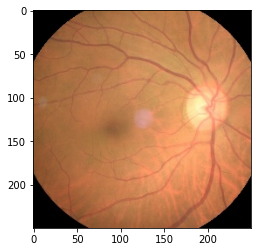

In [19]:
for image, label in resampled_named_ds.take(6):
  plt.imshow(image.numpy())
  print('label: ', CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]], label.numpy())

In [20]:
def randomly_augment(image,label):
  image = tf.image.random_flip_left_right(image)
  #image = tf.image.central_crop(image, central_fraction=0.9)
  #image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return image, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  #ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=False)
  #ds = ds.map(randomly_augment, num_parallel_calls=AUTOTUNE)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE, drop_remainder=True)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  ds = ds.cache()
  ds = ds.batch(32, drop_remainder=True) #all elemetnts for training should be batched in one!
  ds = ds.repeat()

  return ds

In [21]:
final_train_ds = prepare_for_training(resampled_named_ds,cache=True,shuffle_buffer_size=3000)
final_test_ds = prepare_for_testing(test_named_ds,cache=True,shuffle_buffer_size=100)

[1 0 0 0]


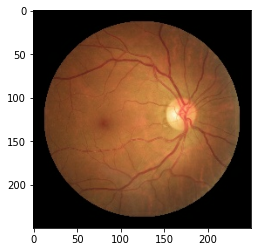

In [22]:
for example in final_train_ds.take(1):
  image, label = example
  break
im, lab = image[13], label[13]
plt.imshow(im.numpy())
print(lab.numpy())

In [23]:
model_cnn = tf.keras.Sequential([
    
    # 1st VGG block
    tf.keras.layers.Conv2D(32, (5, 5), padding = "same", input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(32, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Dropout(0.45),

    #2nd VGG block
    tf.keras.layers.Conv2D(128, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(128, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Dropout(0.45),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(4, activation = 'softmax')
])

In [26]:
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model_cnn.summary()
history_cnn = model_cnn.fit(final_train_ds,
                    #batch_size=32,
                    epochs=2,
                    steps_per_epoch = 200, #train_elements/batch_size
                    validation_data=final_test_ds,
                    validation_steps = 33,
                    use_multiprocessing=True,
                    #class_weight=class_weight
                    )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 250, 250, 32)     96        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 250, 250, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 32)      25632     
                                                                 
 batch_normalization_1 (Batc  (None, 250, 250, 32)     96        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 250, 250, 32)      0

KeyboardInterrupt: ignored

In [27]:
model_cnn.evaluate(final_test_ds, steps=100)

100/100 [==============================] - 13s 131ms/step - loss: 0.6848 - accuracy: 0.8297 - precision: 0.8370 - recall: 0.8200


[0.684827983379364, 0.8296874761581421, 0.837001621723175, 0.8199999928474426]